In [ ]:
import keras
keras.__version__

import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Instructiona**


*   Mount Drive
*   Change the Training and Validation paths with the Working_Images and Working_Validation_Images folders
*   Modify the classes to be evaluated choose between these letters **elegir entre estas letras ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O'] (For example, in In this case, the 8 classes will be evaluate)**


In [ ]:
import os, shutil

########################### EDIT #############################################

# Paths
Entrenamiento = "/content/drive/My Drive/Taller DL/projecto dL/ODIR-5K/ODIR-5K/Working_Images"
Validacion = "/content/drive/My Drive/Taller DL/projecto dL/ODIR-5K/ODIR-5K/Working_Validation_Images/"

# SELECT CLASSES
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M']

#------------------- -EXAMPLES -----------------------------------------------
#CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
#CLASS_NAMES = ['N', 'C']
################################################################################

In [ ]:
# Funcion para obtener una lista de todos los paths

def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

A list of image paths is loaded for later consideration in training. This is done in order not to have to create a folder of training images for the different combinations of the classes.

In [ ]:
training_paths = getListOfFiles(Entrenamiento)
validation_paths = getListOfFiles(Validacion)


random.shuffle(training_paths)
random.shuffle(validation_paths)

In [ ]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0] * len(CLASS_NAMES)
  flag = 0

  for e in label:
      if e != '&' and e != 'X':
        try:
          idx = CLASS_NAMES.index(e)
        except ValueError:
          flag = 1
        else:
          l[idx] = 1      
  return l, flag

In [ ]:
def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3) #
  img = tf.image.convert_image_dtype(img, tf.float32)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label, flag = get_label(name)
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label, flag

**ESTA PARTE TOMA BASTANTE TIEMPO**

In [ ]:
X_train = []
X_labels= []

for i in range(7000):
  img, labels, flag = process_path(training_paths[i])
  if sum(labels) == 1 and (flag == 0):
     X_train.append(img)
     X_labels.append(labels)
X_train = np.stack(X_train)
X_labels = np.stack(X_labels)


In [ ]:
Y_train = []
Y_labels= []

for i in range(1500):
  img, labels, flag = process_path(validation_paths[i])
  if sum(labels) == 1 and (flag == 0): 
     Y_train.append(img)
     Y_labels.append(labels)
Y_train = np.stack(Y_train)
Y_labels = np.stack(Y_labels)

In [ ]:
# Display training set and validation set information used in the network
print(X_train.shape)
print(X_labels.shape)
print(Y_train.shape)
print(Y_labels.shape)

print('Total de imagenes para el entrenamiento: ', X_train.shape[0])
print('Total de imagenes para la validacion: ', Y_train.shape[0])

(6055, 250, 250, 3)
(6055, 7)
(1131, 250, 250, 3)
(1131, 7)
Total de imagenes para el entrenamiento:  6055
Total de imagenes para la validacion:  1131


**Neural Network Model**

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()

In [ ]:
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(250, 250, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [ ]:
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(len(CLASS_NAMES), activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

In [ ]:
from keras import optimizers

history = model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),  
              metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])


# **Training**

In [ ]:
import time
tic = time.time()

history= model.fit(x = X_train, 
             y = X_labels,
             validation_split = 0.10, 
             epochs = 100,
             batch_size=64,
             verbose=1)

print('seconds=', time.time()-tic)

Epoch 1/100
86/86 [==============================] - 12s 136ms/step - loss: 1.7478 - acc: 0.3034 - precision: 0.2380 - recall: 0.3564 - val_loss: 1.6404 - val_acc: 0.3135 - val_precision: 0.3737 - val_recall: 0.1221
Epoch 2/100
86/86 [==============================] - 11s 127ms/step - loss: 1.4942 - acc: 0.4291 - precision: 0.7235 - recall: 0.0778 - val_loss: 1.5659 - val_acc: 0.4653 - val_precision: 0.8382 - val_recall: 0.0941
Epoch 3/100
86/86 [==============================] - 11s 128ms/step - loss: 1.3427 - acc: 0.4995 - precision: 0.8911 - recall: 0.0571 - val_loss: 2.2953 - val_acc: 0.2657 - val_precision: 0.3695 - val_recall: 0.1238
Epoch 4/100
86/86 [==============================] - 11s 128ms/step - loss: 1.2408 - acc: 0.5388 - precision: 0.9162 - recall: 0.0582 - val_loss: 1.2238 - val_acc: 0.5710 - val_precision: 1.0000 - val_recall: 0.0825
Epoch 5/100
86/86 [==============================] - 11s 128ms/step - loss: 1.1495 - acc: 0.5713 - precision: 0.9600 - recall: 0.0617 - 

**Graphs**

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


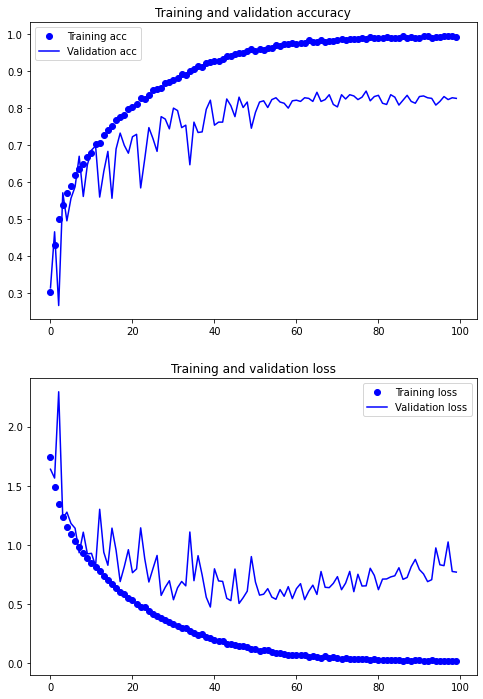

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

acc4 = history.history['acc']
val_acc4 = history.history['val_acc']
loss4 = history.history['loss']
val_loss4 = history.history['val_loss']

epochs = range(len(acc4))

plt.figure(figsize=(8,12))

plt.subplot(211)
plt.plot(epochs, acc4, 'bo', label='Training acc')
plt.plot(epochs, val_acc4, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()


plt.subplot(212)
plt.plot(epochs, loss4, 'bo', label='Training loss')
plt.plot(epochs, val_loss4, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig('convnet_aug_p200epch.eps')
plt.show()

**Matriz de confusion**

In [ ]:
import numpy as np

test_predicted_labels = model.predict(Y_train)
test_true_labels      = np.argmax(Y_labels,axis=-1)
test_predicted_labels = np.argmax(test_predicted_labels,axis=1)

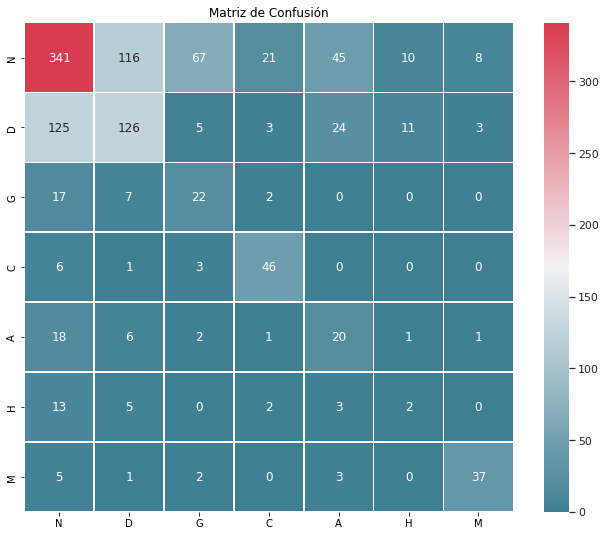

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score 
from sklearn.metrics import f1_score, cohen_kappa_score
import seaborn as sns 


labels = CLASS_NAMES
C = confusion_matrix(test_true_labels, test_predicted_labels)

f, ax = plt.subplots(figsize=(11, 9))
sns.set()
cmap = sns.diverging_palette(220, 8, as_cmap=True)
ax = sns.heatmap(C, cmap=cmap, square=True,
                 annot=True, fmt='d', linewidths=.5)
ax.set_title('Matriz de Confusión')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.show()